# Data preparation code 

Development of functions contained in `data_preparation` module and sensor channel selection

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import copy
from natsort import natsorted
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

#### Select files containing data

In [4]:
data_dir = '<path-to-dataset>'

file_list = os.listdir(data_dir)
file_list.remove('documentation.txt')
file_list.remove('description.txt')
file_list = natsorted(file_list)

print(file_list)

['CE.txt', 'CP.txt', 'EPS1.txt', 'FS1.txt', 'FS2.txt', 'PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt', 'PS6.txt', 'SE.txt', 'TS1.txt', 'TS2.txt', 'TS3.txt', 'TS4.txt', 'VS1.txt', 'profile.txt']


#### Load files into dictionary

In [5]:
data = {}

for file in file_list:
    print(file)
    data[file[:-4]] = np.loadtxt(os.path.join(data_dir, file))

CE.txt
CP.txt
EPS1.txt
FS1.txt
FS2.txt
PS1.txt
PS2.txt
PS3.txt
PS4.txt
PS5.txt
PS6.txt
SE.txt
TS1.txt
TS2.txt
TS3.txt
TS4.txt
VS1.txt
profile.txt


#### Covert condition levels into condition labels

In [6]:
labels = []
for i in range(4):
    label_i = data['profile'][:,i].astype(int)
    for j,val in enumerate(np.sort(np.unique(label_i))):
        label_i[label_i==val] = j
    labels.append(label_i.reshape(-1,1))
labels = np.concatenate(labels, axis=1)
data['labels'] = labels
data.pop('profile', None)

array([[  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       ...,
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.]])

#### Interpolate sequences to unique sampling

In [7]:
t = 60 # cycle duration [s]
n_i = 6000
x_i = np.linspace(0,t,n_i)

data_int = {}
channels = [c for c in data.keys() if c!='labels']
for channel in [key for key in channels if 'condition' not in key]:
    if data[channel].shape[1] != n_i:
        x = np.linspace(0,t,len(data[channel][0]))
        Y = data[channel]
        f = interp1d(x, Y, kind='linear')
        Y_i = f(x_i)
        data_int[channel] = Y_i
    else:
        data_int[channel] = data[channel]

#### Scale data
Combine all sequence for the same sensor togheter for more effective transformation and correlation

In [8]:
df = pd.DataFrame({k: v.reshape(-1,1).squeeze() for k,v in data_int.items()})
array = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(data=array, columns=df.columns)

#### Eliminate sensors that are highly correlated between each other
A simple trail and error approach is used to filter out sensors with a correlation above a threshold of 95%

In [9]:
eliminate = ['TS1','TS2','TS3','TS4','PS6','EPS1','CE','FS2']
df_scaled = df_scaled[[col for col in df_scaled.columns if col not in eliminate]]
corr = df_scaled.corr()

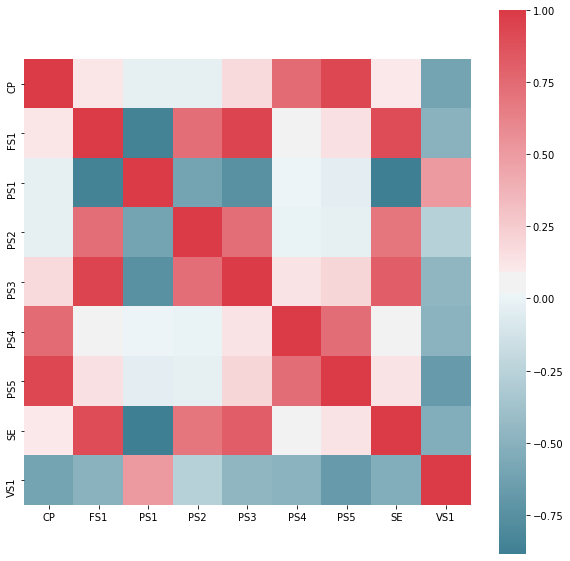

In [10]:
mask = (corr>0.95) | (corr<-.95)
# corr = corr[mask]
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Visualise an example of two sensors that are moderatly correlated

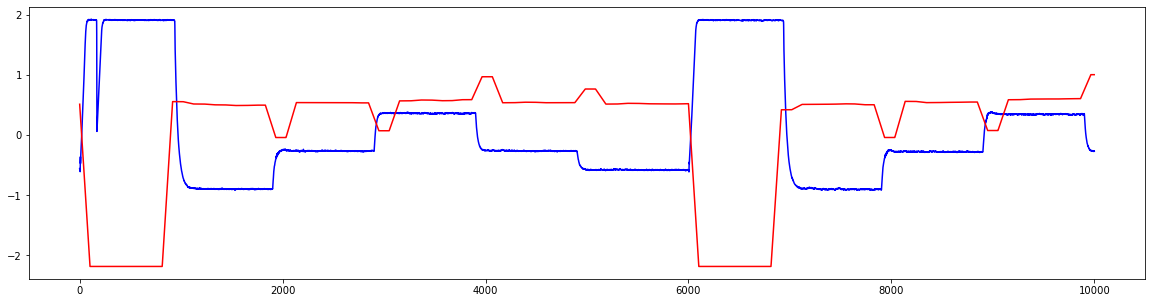

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(df_scaled['PS1'].values[:10000], 'b')
ax.plot(df_scaled['SE'].values[:10000], 'r')